The goal of this notebook is to analyze the fMRI data from the HCP dataset and perform first-based GLM and second-based GLM

In [49]:
#add all the package necessary
import os
import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns
import tarfile
import matplotlib.pyplot as plt

In [50]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [51]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['mental','rnd']}
}

In [52]:
import os
import tarfile
import numpy as np

HCP_DIR = r'C:\Users\Léandre\Desktop\projet asus\Neuromatch\hcp_task'
subjects_file = os.path.join(HCP_DIR, 'subjects_list.txt')

subjects = np.loadtxt(subjects_file, dtype=str)
print(f"Loaded {len(subjects)} subjects:")
print(subjects[:5])  # Show the first 5

Loaded 100 subjects:
['100307' '100408' '101915' '102816' '103414']


Downloading this dataset will create the regions.npy file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided in the Supplement to Glasser et al. 2016.

Information about the network parcellation is provided in Ji et al, 2019.

In [53]:
import numpy as np
import pandas as pd

# Load and prepare region data
data = np.load(r'C:\Users\Léandre\Desktop\projet asus\Neuromatch\hcp_task\regions.npy', allow_pickle=True)
regions = data.T
N_PARCELS = regions.shape[1]

region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right'] * int(N_PARCELS / 2) + ['Left'] * int(N_PARCELS / 2)
)

# Subsetting function
def get_region_subset(labels, region_info):
    indices = [i for i, name in enumerate(region_info['name']) if name in labels]
    return {
        'name': [region_info['name'][i] for i in indices],
        'network': [region_info['network'][i] for i in indices],
        'hemi': [region_info['hemi'][i] for i in indices]
    }


Help functions
We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task.

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [54]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

In [55]:
my_exp = 'SOCIAL'
my_subj = subjects[6]
my_run = 1

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
print(data.shape)

(360, 274)


In [56]:
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)

In [57]:
# we need a little function that averages all frames from any given condition
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)


mental_activity = average_frames(data, evs, my_exp, 'mental')
rnd_activity = average_frames(data, evs, my_exp, 'rnd')
contrast = mental_activity - rnd_activity  # difference between left and right hand movement

# Create main DataFrame
df = pd.DataFrame({
    'mental_activity': mental_activity,
    'rnd_activity': rnd_activity,
    'network': region_info['network'],
    'hemi': region_info['hemi'],
    'region': region_info['name']
})

# Filter by region group
tpj_df = df[df['region'].isin(tpj_info['name'])]
mpfc_df = df[df['region'].isin(mpfc_info['name'])]
pcc_df = df[df['region'].isin(pcc_info['name'])]

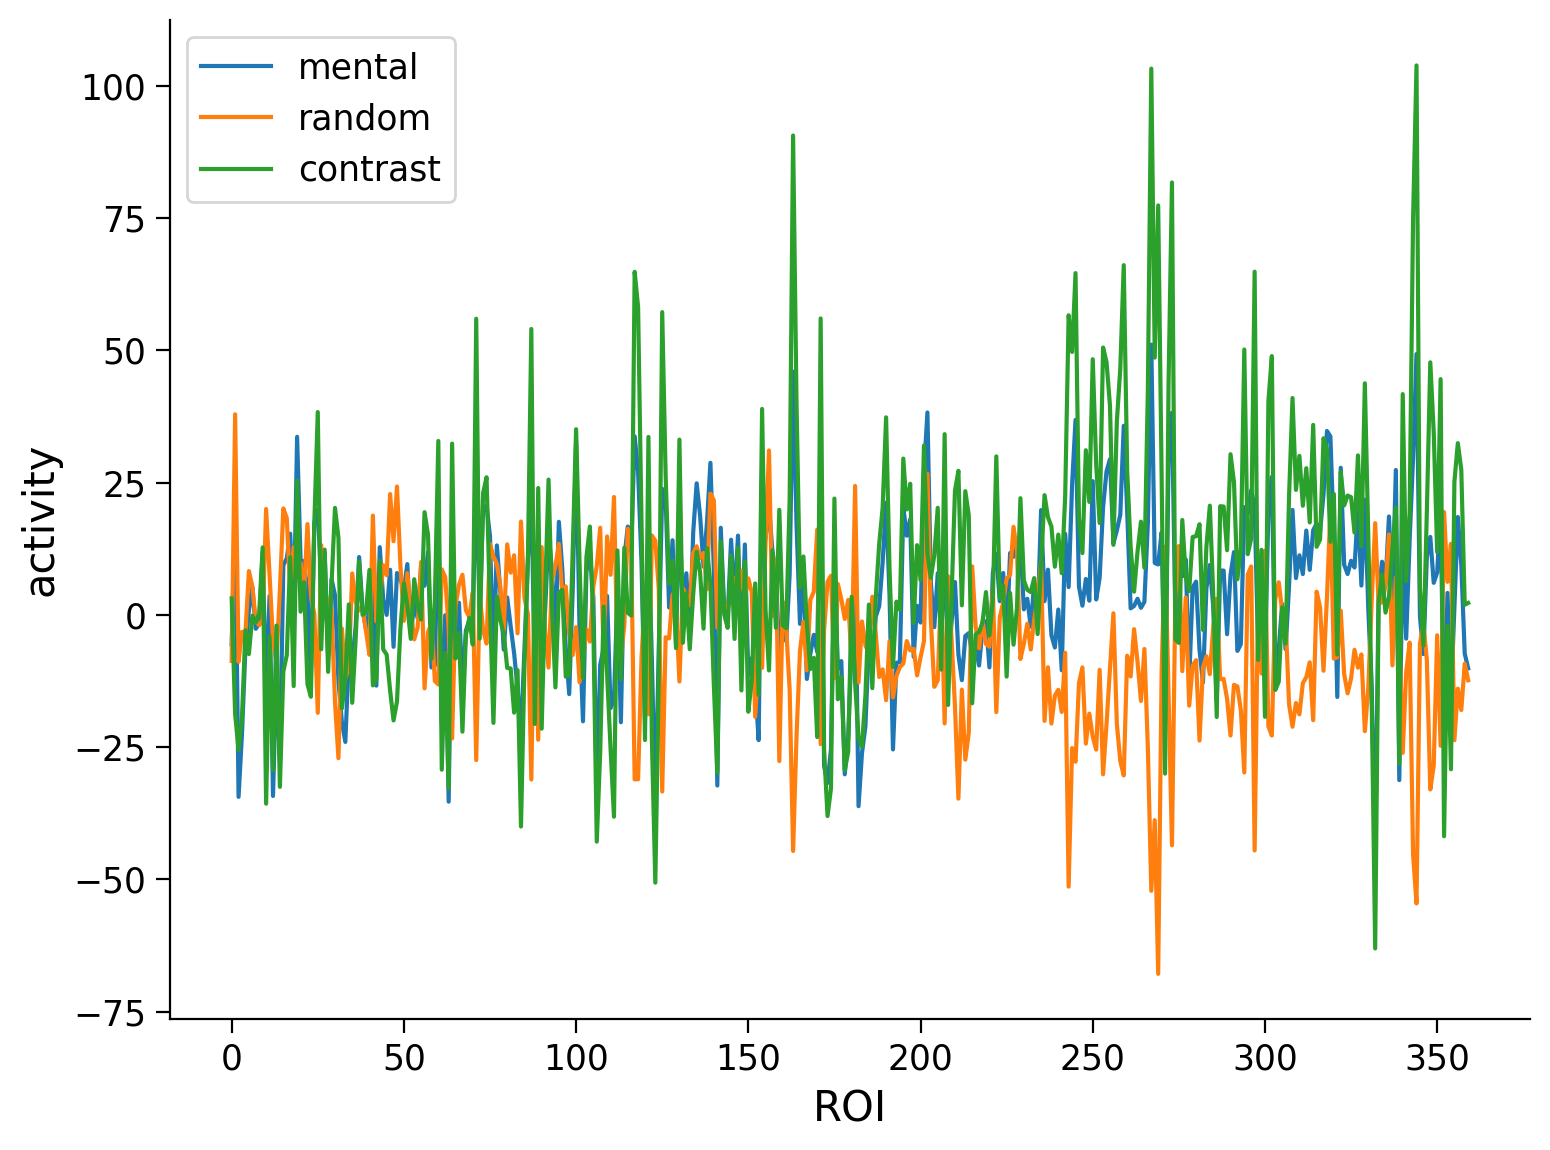

,mental_activity,rnd_activity,network,hemi,region
0,-5.602566,-8.704067,Visual1,Right,R_V1
1,19.175181,37.888163,Visual2,Right,R_MST
2,-34.389673,-8.862957,Visual2,Right,R_V6
3,-22.383813,-3.218729,Visual2,Right,R_V2
4,-6.294933,-3.384225,Visual2,Right,R_V3


In [58]:
# Plot activity level in each ROI for both conditions
plt.plot(mental_activity,label='mental')
plt.plot(rnd_activity,label='random')
plt.plot(contrast,label='contrast')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

df.head()

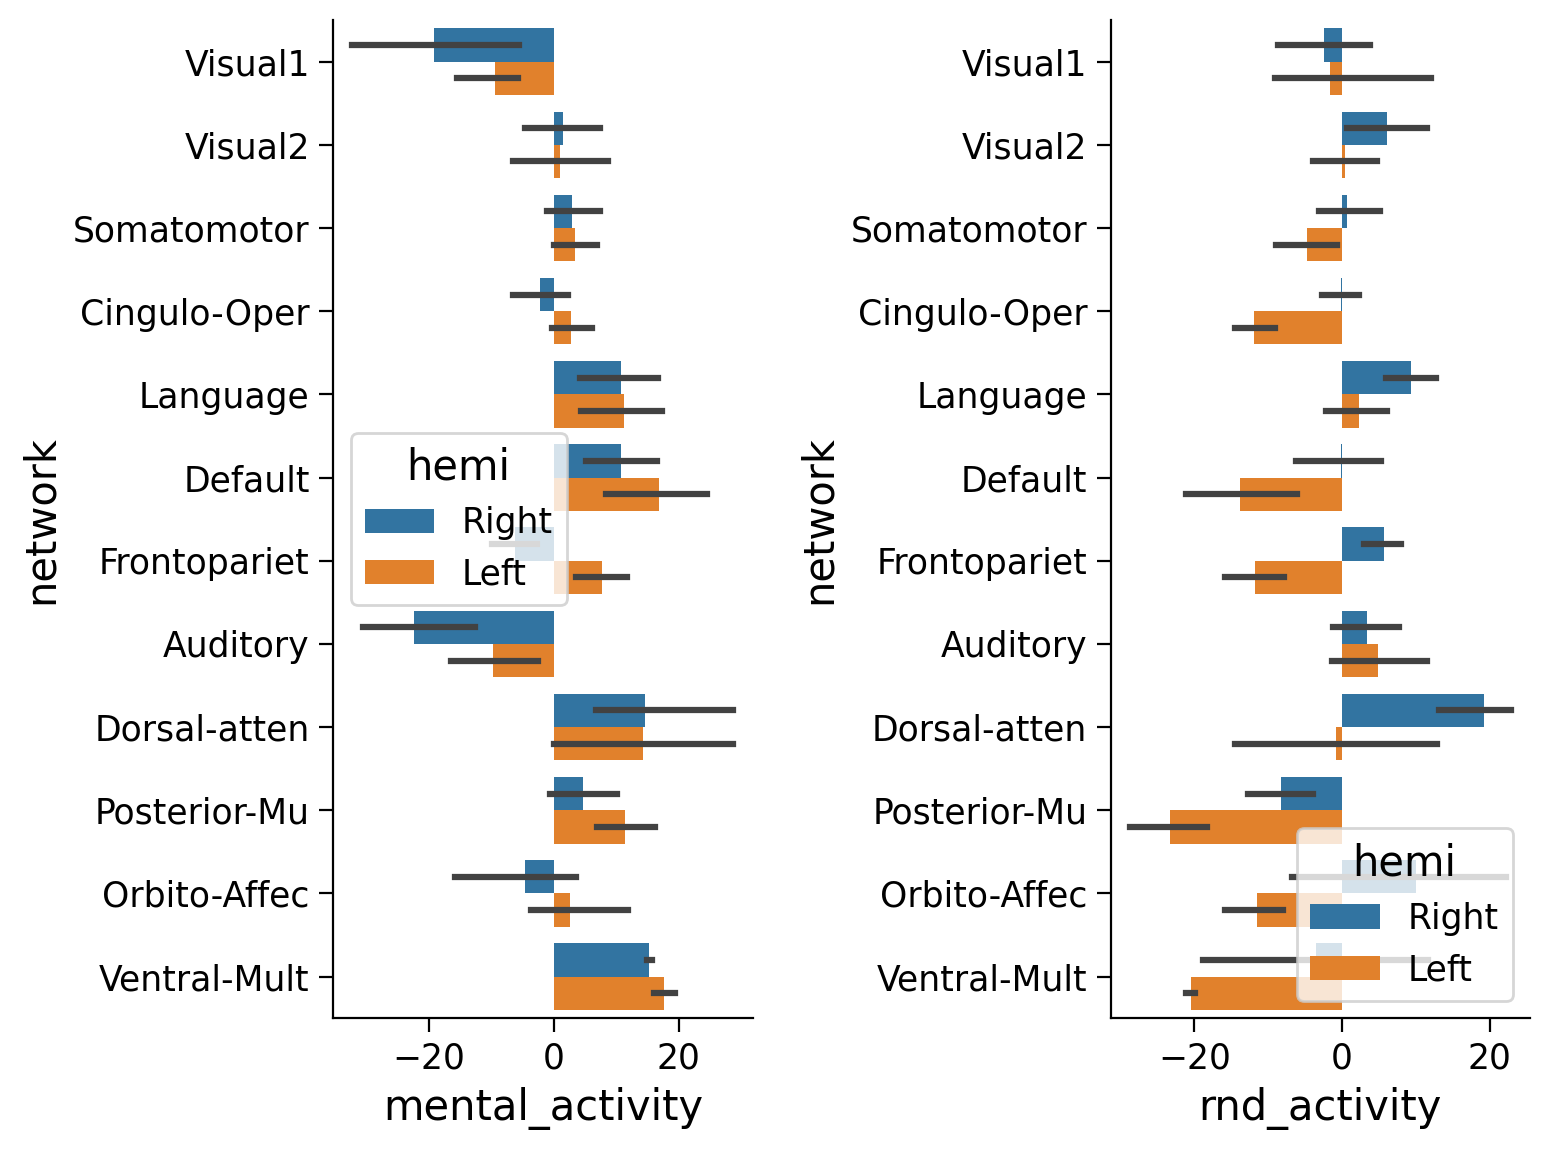

In [59]:
df_vis = pd.DataFrame({'mental_activity' : mental_activity,
                   'rnd_activity' : rnd_activity,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(y='network', x='mental_activity', data=df_vis, hue='hemi',ax=ax1)
sns.barplot(y='network', x='rnd_activity', data=df_vis, hue='hemi',ax=ax2)
plt.show()



In [60]:
#Helper function to plot the ROI groups + contrast
tpj_df = df[df['region'].isin(tpj_info['name'])]
mpfc_df = df[df['region'].isin(mpfc_info['name'])]
pcc_df = df[df['region'].isin(pcc_info['name'])]


def plot_region_activity(region_df, region_name):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    sns.barplot(y='region', x='mental_activity', data=region_df, hue='hemi', ax=ax1)
    ax1.set_title(f'Mental Activity in {region_name} Regions')

    sns.barplot(y='region', x='rnd_activity', data=region_df, hue='hemi', ax=ax2)
    ax2.set_title(f'Random Activity in {region_name} Regions')

    
    plt.tight_layout()
    plt.show()



def plot_contrast(region_df, region_name):
    plt.figure(figsize=(10, 6))
    sns.barplot(y='region', x='contrast', data=region_df, hue='hemi', palette='coolwarm')
    plt.axvline(0, color='gray', linestyle='--')
    plt.title(f'Contrast: Mental - Random Activity in {region_name}')
    plt.xlabel('Contrast Value')
    plt.ylabel('Region')
    plt.tight_layout()
    plt.show()

 


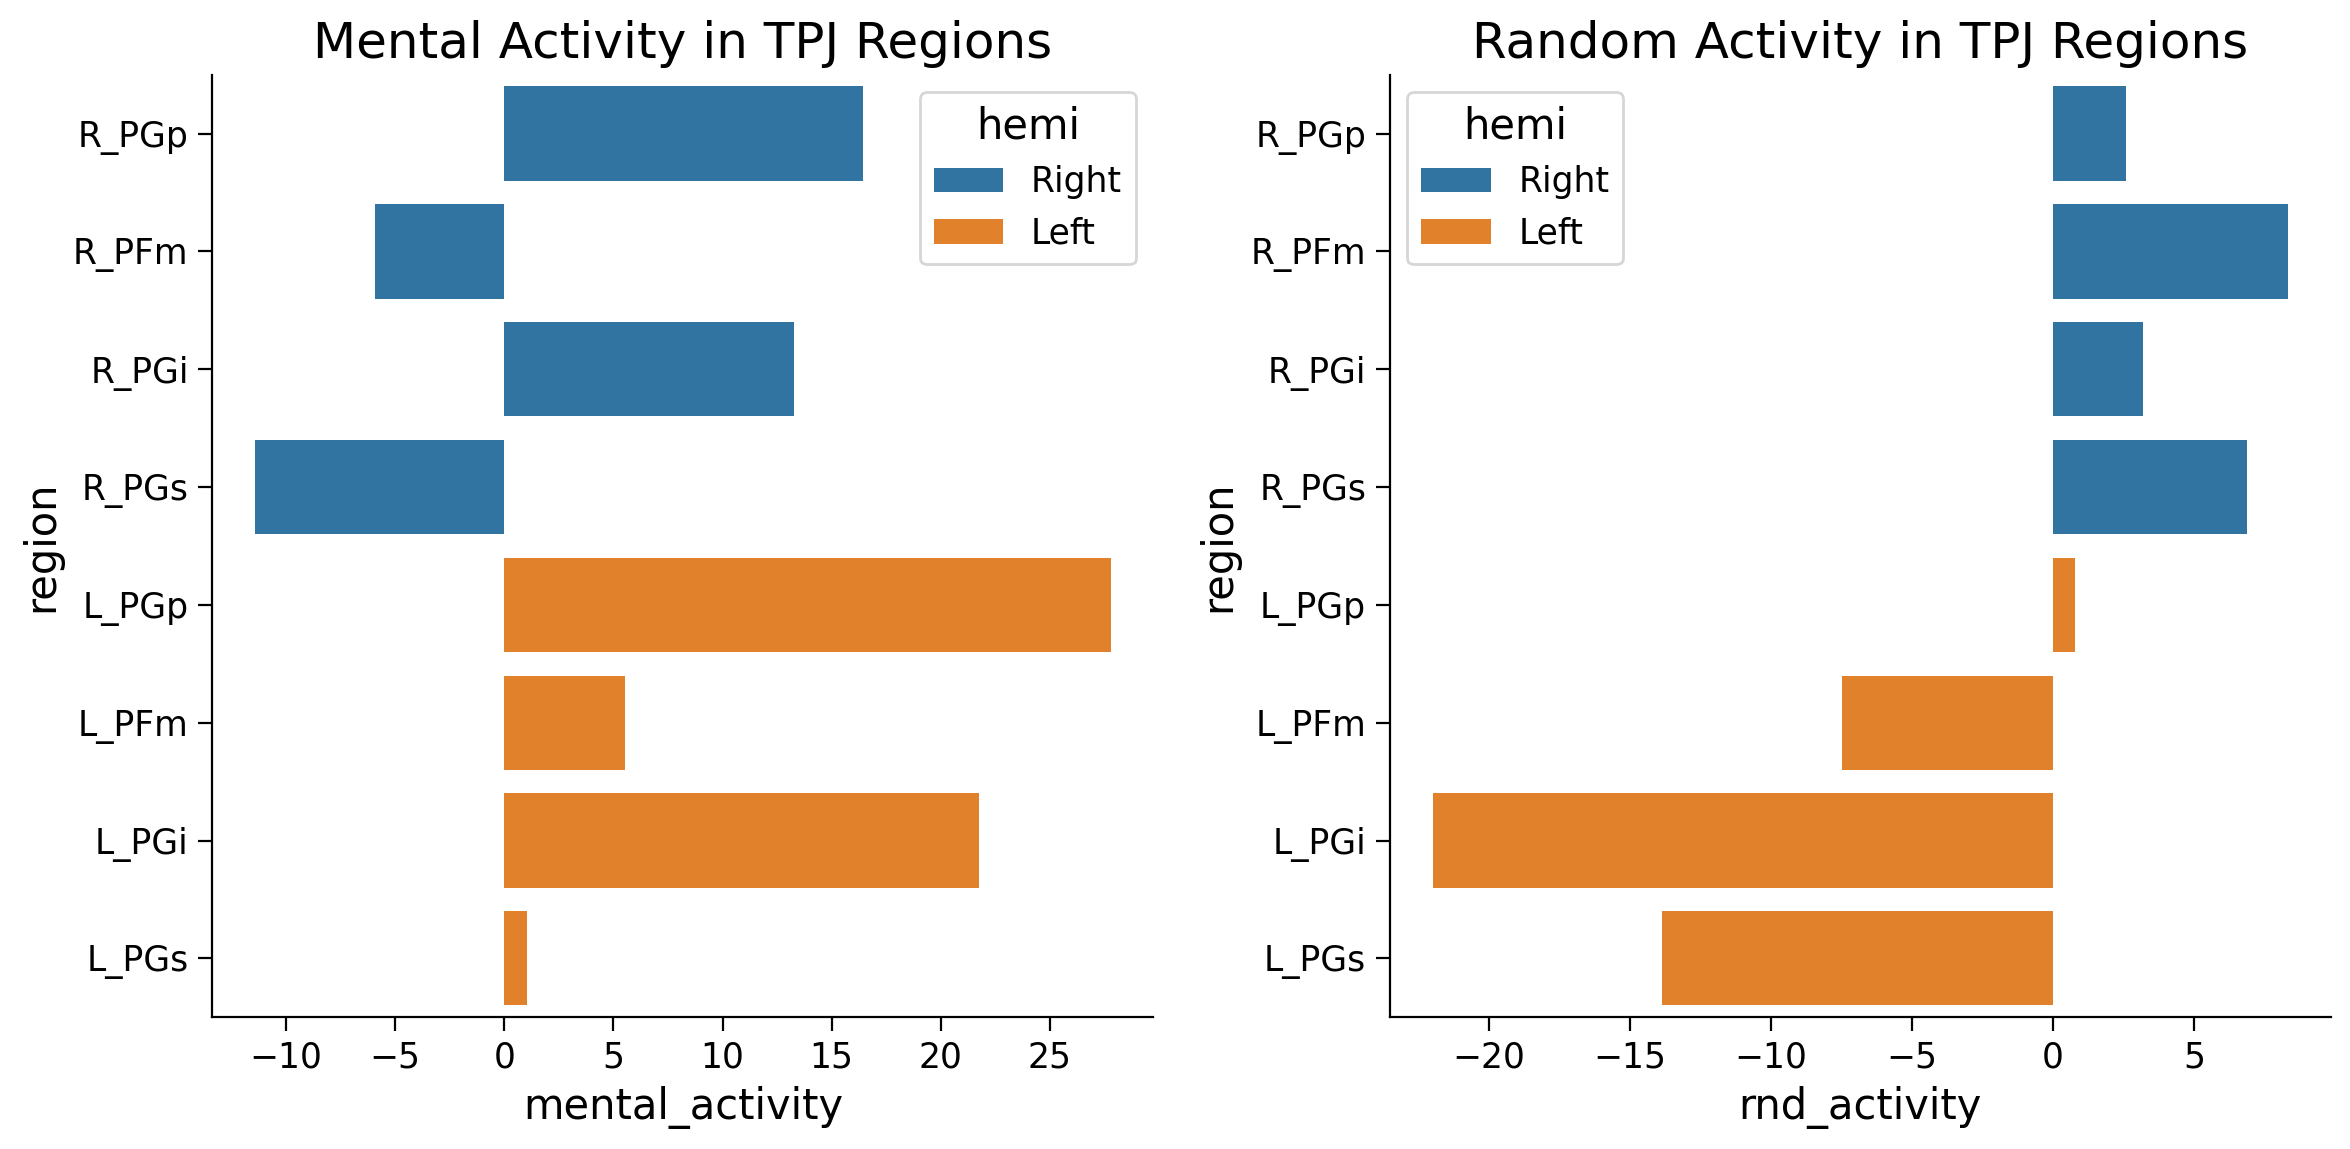

ValueError: Could not interpret value `contrast` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [61]:
plot_region_activity(tpj_df, 'TPJ')
plot_contrast(tpj_df, 'TPJ')

plot_region_activity(mpfc_df, 'MPFC')
plot_contrast(mpfc_df, 'mPFC')

plot_region_activity(pcc_df, 'PCC')
plot_contrast(pcc_df, 'PCC')

Ok now is the part where I'm gonna attempt to do a GLM analysis

With this cell, I took a part of Briha's code and adapted it with the code I had previously written, to compute all of participant's ROI activation in a single panda table.

In [62]:
#Here, I select the regions of the ROI we are looking at (mPFC, TPJ and PCC) that are better represented by the Glasser parcellation
#Need some double check


#Briha's region
#mpfc_regions = ['R_10r', 'R_9m', 'R_9p', 'R_10d', 'R_p9-46v', 'R_a9-46v', 'R_9-46d', 'R_9a', 'R_10v', 'R_a10p', 'R_10pp', 'R_p10p',
 #               'L_10r', 'L_9m', 'L_9p', 'L_10d', 'L_p9-46v', 'L_a9-46v', 'L_9-46d', 'L_9a', 'L_10v', 'L_a10p', 'L_10pp', 'L_p10p']
#tpj_regions = ['R_PGp', 'R_PFm', 'R_PGi', 'R_PGs', 'L_PGp', 'L_PFm', 'L_PGi', 'L_PGs']
#pcc_regions = ['R_23d', 'R_v23ab', 'R_d23ab', 'R_31pv', 'R_23c', 'R_31pd', 'R_31a',
#               'L_23d', 'L_v23ab', 'L_d23ab', 'L_31pv', 'L_23c', 'L_31pd', 'L_31a']

mpfc_labels_R = ['R_10r', 'R_9m', 'R_9p', 'R_10d', 'R_p9-46v', 'R_a9-46v', 'R_9-46d', 'R_9a', 'R_10v', 'R_a10p', 'R_10pp', 'R_p10p']

mpfc_labels_L = ['L_10r', 'L_9m', 'L_9p', 'L_10d', 'L_p9-46v', 'L_a9-46v', 'L_9-46d', 'L_9a', 'L_10v', 'L_a10p', 'L_10pp', 'L_p10p']   

tpj_labels_R = ['R_PGp', 'R_PFm', 'R_PGi', 'R_PGs']
              
tpj_labels_L = [ 'L_PGp', 'L_PFm', 'L_PGi', 'L_PGs']        

pcc_labels_R = ['R_23d', 'R_v23ab', 'R_d23ab', 'R_31pv', 'R_23c', 'R_31pd', 'R_31a']

pcc_labels_L = ['L_23d', 'L_v23ab', 'L_d23ab', 'L_31pv', 'L_23c', 'L_31pd', 'L_31a']
# Combine all labels into one mapping dictionary
region_label_map = {}

# Add MPFC labels
for label in mpfc_labels_R:
    region_label_map[label] = 'MPFC_R'

for label in mpfc_labels_L:
    region_label_map[label] = 'MPFC_L'

# Add TPJ labels
for label in tpj_labels_R:
    region_label_map[label] = 'TPJ_R'

for label in tpj_labels_L:
    region_label_map[label] = 'TPJ_L'   

# Add PCC labels
for label in pcc_labels_R:
    region_label_map[label] = 'PCC_R'

for label in pcc_labels_L:
    region_label_map[label] = 'PCC_L'

# Helper function to find region indices
def get_indices(target_group, region_labels):
    return [i for i, label in enumerate(region_labels) if region_label_map.get(label) == target_group]


# Final result container
subject_contrast_data = {
    'subject': [],
    'MPFC_R': [],
    'TPJ_R': [],
    'PCC_R': [],
    'MPFC_L': [],
    'TPJ_L': [],
    'PCC_L': []
}

for subj in subjects:
    print(f"Processing subject: {subj}")
    
    mpfc_R_contrasts = []
    tpj_R_contrasts = []
    pcc_R_contrasts = []
    mpfc_L_contrasts = []
    tpj_L_contrasts = []
    pcc_L_contrasts = []

    for run in [0, 1]:  # Run LR and RL
        # Load fMRI timeseries and event structure
        data = load_single_timeseries(subject=subj, experiment='SOCIAL', run=run, remove_mean=True)
        evs = load_evs(subject=subj, experiment='SOCIAL', run=run)

        # Get region labels for this subject (assuming each subject has same region list)
        region_labels = tpj_labels + pcc_labels + mpfc_labels
   # <- Make sure this returns a list of parcel names

        # Get indices per group
        mpfc_R_idx = get_indices('MPFC_R', region_labels)
        tpj_R_idx = get_indices('TPJ_R', region_labels)
        pcc_R_idx = get_indices('PCC_R', region_labels)
        mpfc_L_idx = get_indices('MPFC_L', region_labels)
        tpj_L_idx = get_indices('TPJ_L', region_labels)
        pcc_L_idx = get_indices('PCC_L', region_labels)


        # Compute condition contrast: mental > rnd
        mental = average_frames(data, evs, 'SOCIAL', 'mental')
        rnd = average_frames(data, evs, 'SOCIAL', 'rnd')
        contrast = mental - rnd

        # Extract mean contrast per region
        mpfc_R_contrasts.append(np.mean(contrast[mpfc_R_idx]))
        tpj_R_contrasts.append(np.mean(contrast[tpj_R_idx]))
        pcc_R_contrasts.append(np.mean(contrast[pcc_R_idx]))
        mpfc_L_contrasts.append(np.mean(contrast[mpfc_L_idx]))
        tpj_L_contrasts.append(np.mean(contrast[tpj_L_idx]))
        pcc_L_contrasts.append(np.mean(contrast[pcc_L_idx]))

    # Store average contrast across both runs
    subject_contrast_data['subject'].append(subj)
    subject_contrast_data['MPFC_R'].append(np.mean(mpfc_R_contrasts))
    subject_contrast_data['TPJ_R'].append(np.mean(tpj_R_contrasts))
    subject_contrast_data['PCC_R'].append(np.mean(pcc_R_contrasts))
    subject_contrast_data['MPFC_L'].append(np.mean(mpfc_L_contrasts))
    subject_contrast_data['TPJ_L'].append(np.mean(tpj_L_contrasts))
    subject_contrast_data['PCC_L'].append(np.mean(pcc_L_contrasts))


# Convert to DataFrame
contrast_df = pd.DataFrame(subject_contrast_data)
print(contrast_df.head())

Processing subject: 100307
Processing subject: 100408
Processing subject: 101915
Processing subject: 102816
Processing subject: 103414
Processing subject: 103515
Processing subject: 103818
Processing subject: 105115
Processing subject: 105216
Processing subject: 106016
Processing subject: 106319
Processing subject: 110411
Processing subject: 111009
Processing subject: 111312
Processing subject: 111514
Processing subject: 111716
Processing subject: 113215
Processing subject: 113619
Processing subject: 114924
Processing subject: 115320
Processing subject: 117122
Processing subject: 117324
Processing subject: 118730
Processing subject: 118932
Processing subject: 119833
Processing subject: 120111
Processing subject: 120212
Processing subject: 122317
Processing subject: 123117
Processing subject: 124422
Processing subject: 125525
Processing subject: 126325
Processing subject: 127933
Processing subject: 128632
Processing subject: 129028
Processing subject: 130013
Processing subject: 130316
P

In [46]:
# Create subsets
tpj_R_info = get_region_subset(tpj_labels_R, region_info)
mpfc_R_info = get_region_subset(mpfc_labels_R, region_info)
pcc_R_info = get_region_subset(pcc_labels_R, region_info)
tpj_L_info = get_region_subset(tpj_labels_L, region_info)
mpfc_L_info = get_region_subset(mpfc_labels_L, region_info)
pcc_L_info = get_region_subset(pcc_labels_L, region_info)


import pandas as pd

# Convert dictionaries to DataFrames and label their origin
tpj_R_df = pd.DataFrame(tpj_R_info)
tpj_R_df["Region"] = "TPJ_R"

mpfc_R_df = pd.DataFrame(mpfc_R_info)
mpfc_R_df["Region"] = "mPFC_R"

pcc_R_df = pd.DataFrame(pcc_R_info)
pcc_R_df["Region"] = "PCC_R"

tpj_L_df = pd.DataFrame(tpj_L_info)
tpj_L_df["Region"] = "TPJ_L"

mpfc_L_df = pd.DataFrame(mpfc_L_info)
mpfc_L_df["Region"] = "mPFC_L"

pcc_L_df = pd.DataFrame(pcc_L_info)
pcc_L_df["Region"] = "PCC_L"

# Concatenate all labeled DataFrames
combined_df = pd.concat([
    tpj_R_df,
    mpfc_R_df,
    pcc_R_df,
    tpj_L_df,
    mpfc_L_df,
    pcc_L_df
], axis=0, ignore_index=True)

print(combined_df)









        name       network   hemi  Region
0      R_PGp      Language  Right   TPJ_R
1      R_PFm  Frontopariet  Right   TPJ_R
2      R_PGi  Posterior-Mu  Right   TPJ_R
3      R_PGs  Posterior-Mu  Right   TPJ_R
4      R_10r  Posterior-Mu  Right  mPFC_R
5       R_9m  Posterior-Mu  Right  mPFC_R
6       R_9p  Posterior-Mu  Right  mPFC_R
7      R_10d  Posterior-Mu  Right  mPFC_R
8   R_p9-46v  Frontopariet  Right  mPFC_R
9   R_a9-46v  Frontopariet  Right  mPFC_R
10   R_9-46d  Cingulo-Oper  Right  mPFC_R
11      R_9a  Posterior-Mu  Right  mPFC_R
12     R_10v  Posterior-Mu  Right  mPFC_R
13    R_a10p  Frontopariet  Right  mPFC_R
14    R_10pp  Posterior-Mu  Right  mPFC_R
15    R_p10p  Frontopariet  Right  mPFC_R
16     R_23d  Posterior-Mu  Right   PCC_R
17   R_v23ab  Posterior-Mu  Right   PCC_R
18   R_d23ab  Posterior-Mu  Right   PCC_R
19    R_31pv  Posterior-Mu  Right   PCC_R
20     R_23c  Cingulo-Oper  Right   PCC_R
21    R_31pd  Posterior-Mu  Right   PCC_R
22     R_31a  Posterior-Mu  Right 

In [26]:
#Save the ROI
contrast_df.to_csv('TPJ-MPFC-PCC.csv', index=False)